# **Predict2Win: Predicting Next Events in a Football Match**

**Table of Contents**
0. Background
1. Data import
2. Data preparation
3. Methods  
    3.1 Single Layer Baseline
    3.2 LSTM
    3.3 Transformer
4. Results
5. Discussion
6. Division of labour
7. References

## Disclaimer  
Parts of this code were adapted from Seq2Event (Simpson et al., 2022), a project following the same goal as us. No code was copy pasted, only the logic was adapted. Furthermore, parts of this code were written with the help of AI. No code was copy pasted directly from AI.

### Background
The goal of this project was to build a machine learning model that could predict the next event in a match (e.g. shot or pass), given some preceding events.
Trying to predict football matches is common and in fact a lot of information about potential game outcomes is presented before the game (e.g. bet projections) and during the game (e.g. expected goals). And still, if predictions like these were accurate, companies offering sport bets would go bankrupt. Clearly, there is yet to be an algorithm that outperforms the state of the art.
Football matches are inherently noisy. Players make mistakes, referees make questionable calls and sometimes the outcome of a match boils down to dumb luck. Still, previous literature (Simpson et al., 2022) has shown that machine learning models are able to find structure in the data and make accurate predictions about what will happen next in the match. In this project, we are trying to apply the logic of a next-word prediction model like GPT2 to football data and build a custom transformer model to predict the next event, given a sequence of previous events. Following this, the performance will be compared to simpler architectures, namely an LSTM and a two-layer fully connected network. The data being used in this project stems from WYSCOUT (Pappalardo et al., 2019), a company aiming to build up large sports datasets. Direct python integration stems from [Kloppy](https://kloppy.pysport.org/) [(PySport)](https://pysport.org/), providing a subset of the complete WYSCOUT dataset. Data includes about 2000 matches from the Top 5 european leagues as well as data from the FIFA World Cup 2018 and the UEFA Euro Cup 2020.

### Installing the requirements:
This project is uploaded to a [GitHub repository](https://github.com/jvli4n/DLiP2025_football_analysis). To run this notebook in the way it was intended, the notebook will install the dependencies from a requirements.txt within this repository.

In [1]:
!pip install -r https://raw.githubusercontent.com/jvli4n/DLiP2025_football_analysis/refs/heads/main/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.7/294.7 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.1/231.1 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.7/246.7 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.8/365.8 kB 43.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


Next, import the relevant distributions:

In [4]:
# Standard Python Library
import os
import time
import copy
import json
import pickle
import requests
import warnings

# Other Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from zipfile import ZipFile

from tqdm.auto import tqdm
from IPython.display import clear_output
from pandas.api.types import is_categorical_dtype
from concurrent.futures import ThreadPoolExecutor, as_completed

from kloppy import wyscout
from kloppy.domain import Provider, Dimension, NormalizedPitchDimensions, Orientation

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler

from torchmetrics.classification import ConfusionMatrix

/root/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## PART 1: DATA IMPORT

**Please note that running the data import and transformation will take approximately 13 minutes. A pickle file is provided below so the data import can be skipped. However, you still need to define the `download_zip` function below.**

In [7]:
def download_zip(url, save_path):
  """
  Helper function to download and unzip files from a url.
  """

  # save location
  save_dir = Path(save_path)
  save_dir.mkdir(parents=True, exist_ok=True)

  # create the zip folder path
  zip_name = url.split("/")[-1]
  zip_stem = zip_name.rsplit(".", 1)[0]
  zip_path = save_dir / zip_name

  # create folder to unzip
  unzip_dir = save_dir / zip_stem
  os.makedirs(unzip_dir, exist_ok=True)

  print(save_dir, zip_name, zip_stem, zip_path, unzip_dir)

  response = requests.get(url) # send GET request
  response.raise_for_status()  # error if download failed

  # download zip file
  with open(zip_path, 'wb') as f:
   f.write(response.content)

  # unzip file
  with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

  print(f"Downloaded: {url.split('/')[-1]}")

Pappalardo et al. (2019) made (part of) their data publicly available on figshare. Below is a code cell to download the data needed for this notebook. **Please specify the path where you would like to save the data before running the cell in case it should not be saved in the current working directory!**

In [4]:
project_path = os.getcwd() # specify path where data should be saved

# match ids for referencing the matches after extracting with kloppy
matches_url = "https://figshare.com/ndownloader/files/14464622/matches.zip"
download_zip(matches_url, project_path)

/content matches.zip matches /content/matches.zip /content/matches
Downloaded: matches.zip


This function is used as a helper function for the next block because distributing it across mutliple CPU cores we need the actual function to load a match separately. After the matches are loaded, they are also transformed with some kloppy functions. First the pitch dimensions are normalized because some providers give different pitch dimensions. Next a standard coordinate system is used for the same reason. Orientations are made static (no halftime switch), this is because the model might get fed a data window from overlapping periods and like this we don't have to specifiy periods and save some memmory.

In [5]:
def load_match(match_id):
    """Helper function for loading a single match with kloppy."""
    try:
        dataset = wyscout.load_open_data(match_id=match_id, coordinates="wyscout")

        # Normalize data
        dataset = dataset.transform(to_pitch_dimensions=NormalizedPitchDimensions(pitch_length=105,
                                                        pitch_width=68,
                                                        x_dim = Dimension(0, 1),
                                                        y_dim = Dimension(0, 1)),
                                    to_coordinate_system = Provider.WYSCOUT,
                                    to_orientation = Orientation.STATIC_HOME_AWAY)
        dataset = dataset.to_df()
        return match_id, dataset

    except Exception as e:
        print(f"Failed match {match_id}: {e}")
        return match_id, None


In [6]:
def load_kloppy(matches_path, save_path):
  """
  Helper function to load and normalize match data from wyscout using kloppy.
  Saves everything into a dictionary with match ids as keys and dataframes for each match as values.
  The dictionary is saved as a pickle file at save_path.
  """
  # The first part get's the matchIDs so we can use them later to load single matches
  matches_dir = Path(matches_path)
  match_ids = [] # buffer for match ids

  # collect json files containing matchid
  for comp in matches_dir.glob("*.json"): # find and loop through .json files
    with comp.open("r") as f:
      data = json.load(f) # load json

      for mtch in data:
        match_ids.append(mtch["wyId"]) #Append unique matchID

  data_dict = {}
  # Parallelize data import and transform
  with ThreadPoolExecutor(max_workers=None) as ex: # Default = all workers
    for match_id, df in tqdm(ex.map(load_match, match_ids), #tqdm creates the loading buffer
                             total=len(match_ids),
                             desc="Loading matches"):
      if df is None:
        continue
      data_dict[match_id] = df # Data fictionary with matchID as key and df as value

  print(f"Total matches loaded: {len(data_dict)}")

  # save dictionary as .pkl
  with open(save_path, "wb") as f:
    pickle.dump(data_dict, f)

  print(f"Dictionary saved at {save_path}")

In [7]:
# load the data using the function
matches_path = os.path.join(project_path, "matches")
dict_path = os.path.join(project_path, "wyscout_data.pkl")
load_kloppy(matches_path, dict_path)

Loading matches:   0%|          | 0/1941 [00:00<?, ?it/s]

Failed match 2576332: 'NoneType' object is not subscriptable


KeyboardInterrupt: 

**NOTE: IF WYSCOUT_DATA DICTIONARY IS SAVED ON DISK START FROM HERE TO SAVE TIME**

The code cell below downloads a dictionary from our GitHub repo that contains the matchids as keys and a dataframe with the corresponding events as values. **Make sure to specify a path where you would like to save the .zip file in case it should not be the current working directory.**

In [10]:
project_path = os.getcwd() # specify path where data should be saved

# data is provided in GitHub repo
github_link = 'https://github.com/jvli4n/DLiP2025_football_analysis/raw/refs/heads/main/wyscout_data.zip'

# download zip from GitHub
download_zip(github_link, project_path)

# extract the data_dict from the .zip file
dict_path = os.path.join(project_path, "wyscout_data.zip")
with ZipFile(dict_path) as zf:
    with zf.open("data/wyscout_data.pkl") as file:
        data_dict = pd.read_pickle(file)

# example match (id: 2058017)
print(data_dict[2058017].head(5))

/datasets/_deepnote_work wyscout_data.zip wyscout_data /datasets/_deepnote_work/wyscout_data.zip /datasets/_deepnote_work/wyscout_data
Downloaded: wyscout_data.zip
    event_id event_type  period_id              timestamp end_timestamp  \
0  263883958       PASS          1 0 days 00:00:01.892339          None   
1  263883959       PASS          1 0 days 00:00:03.889375          None   
2  263883960       PASS          1 0 days 00:00:06.140946          None   
3  263883963       PASS          1 0 days 00:00:09.226570          None   
4  263883964       PASS          1 0 days 00:00:12.658969          None   

  ball_state ball_owning_team team_id player_id  coordinates_x  ...  \
0       None             None    9598     14943       0.500000  ...   
1       None             None    9598     69968       0.607521  ...   
2       None             None    9598      8287       0.654693  ...   
3       None             None    9598     69409       0.692430  ...   
4       None             None 

### Model Hyperparameters
**Please change them here globally**  
`LEARNING RATE` and `PATIENCE` were used because they seemed to yield the best results during tinkering.

In [13]:
WINDOW_SIZE = 30
LEARNING_RATE = 1e-4
PATIENCE = 2 # Wait to epochs before chagning learning rate
DROPOUT_RATE = 0.1 # 10%
BATCH_SIZE = 512 # More = speed
TRANSFORMER_DIMENSION = 128 # Hidden dimension
LSTM_HIDDEN_DIM = None
LSTM_N_CELLS = 2

## PART 2: DATA PREPROCESSING

In this cell the data be transformed into a format, usable by the models. First, going from a dictionary with the matchid as keys and the data as values we concatenate all matches below one another, beginning with a `<BOM>` and ending with a `<EOM>` token. Next a column is added containing all the valid indices where a context window can be place across the whole dataframe. A valid window is defined by the window never overlapping across matches. This way the input never includes data from two separate matches. Additionally, timestamps (in seconds) for each event and the length of each event, as well as  the ∆ coordinates are included as separate columns for additional information. All categorical variables are transformed into their category codes, so they can be put into tensors. NAs are either filled with -1 for numerical variables and with a `<missing>` token for categorical variables. The final dataset is of type `pd.DataFrame` and includes only relevant columns needed for further processing or model training.

In [76]:
# columns of interest
cols = ['event_type', 'period_id', 'team_id', 'player_id', 'success', 'result', # catecorigal
            'timestamp', 'coordinates_x', 'coordinates_y'] # numeric

# beginning of match and end of match tokens
begin = pd.DataFrame(["<BOM>"] + [None] * (len(cols)-1), index=cols).T
end = pd.DataFrame(["<EOM>"] + [None] * (len(cols)-1), index=cols).T

with warnings.catch_warnings(): # Concatenating with NaN will be depracated in next pandas version
    warnings.simplefilter("ignore", FutureWarning)
    for matchid, df in data_dict.items():
      temp_df = df[cols]
      temp_df = pd.concat((begin, temp_df, end), ignore_index= True)
      valid_idx = np.arange(len(temp_df)) + WINDOW_SIZE < len(temp_df)
      temp_df['valid_idx'] = valid_idx.astype(int)
      data_dict[matchid] = temp_df

# concatenate all matches and create match_id column
data_df = pd.concat([df.assign(match_id = id) for id, df in data_dict.items()], ignore_index = True)

# collapse event_type and result columns to create input_event
data_df["input_event"] = data_df.event_type # copy event type column
fltr = data_df.result.notna() # filter out None results
data_df.loc[fltr, "input_event"] = data_df.loc[fltr, "event_type"] + "_" + data_df.loc[fltr, "result"] # add result tags to events

# after inspecting the models' performance, we decided to reduce the number of events
# data_df["input_event"] = data_df.event_type
# goal =

print("Number of unique events (collapsed):", len(data_df.input_event.unique()))

# convert timestamps to seconds
times = data_df.timestamp.dt.total_seconds()
data_df['timestamp_seconds'] = times

# compute delta time and delta x, y coordinates
data_df["delta_x"] = data_df.groupby("match_id").coordinates_x.diff()
data_df["delta_y"] = data_df.groupby("match_id").coordinates_y.diff()
data_df["delta_time"] = data_df.groupby("match_id").timestamp_seconds.diff()

# convert to categorical dtype
factor_cols = ["team_id", "player_id", "input_event"]
data_df[factor_cols] = data_df[factor_cols].astype("category")

# drop columns of no interest
data_df = data_df.drop(columns = ["event_type", "period_id", "success", "result", "timestamp"])

Number of unique events (collapsed): 27


In [79]:
# compute categorical feature dimensions (used later for modelling)
num_teams = len(data_df.team_id.unique())
num_players = len(data_df.player_id.unique())
num_events = len(data_df.input_event.unique())

# replace NA with <missing> token for categorical variables
for col in data_df.columns:
  if isinstance(data_df[col].dtype, pd.CategoricalDtype):
    data_df[col] = data_df[col].cat.add_categories(["<missing>"]).fillna("<missing>")

codes_map = {}

for col in data_df.select_dtypes(["category"]).columns:
    data_df[col] = data_df[col].cat.remove_unused_categories()
    cats = data_df[col].cat.categories # original category
    codes_map[col] = dict(enumerate(cats)) # mapping
    data_df[col] = data_df[col].cat.codes # codes

print("\ncode - label map")
print(pd.Series(codes_map["input_event"]))

print("Number of teams:", num_teams)
print("Number of players:", num_players)
print("Number of events:", num_events)



code - label map
0                    <BOM>
1                    <EOM>
2                 BALL_OUT
3                     CARD
4                CLEARANCE
5                     DUEL
6                DUEL_LOST
7             DUEL_NEUTRAL
8                 DUEL_WON
9           FOUL_COMMITTED
10         GENERIC:generic
11              GOALKEEPER
12       INTERCEPTION_LOST
13        INTERCEPTION_OUT
14    INTERCEPTION_SUCCESS
15              MISCONTROL
16                    PASS
17           PASS_COMPLETE
18         PASS_INCOMPLETE
19            PASS_OFFSIDE
20                PASS_OUT
21                RECOVERY
22            SHOT_BLOCKED
23               SHOT_GOAL
24         SHOT_OFF_TARGET
25               SHOT_POST
26              SHOT_SAVED
dtype: object
Number of teams: 143
Number of players: 3030
Number of events: 27


In [100]:
# Fill all continuous column NAs with -1
data_df = data_df.fillna(-1)

# Create column with labels
label = pd.Series(data_df.input_event[1:].to_numpy())
label[label.index.max() + 1] = data_df.input_event[0:1].item() # shifts labels by 1
label.index = data_df.index # align indices
data_df['label'] = label

**SPLIT INTO TRAIN, VAL AND TEST SETS**

Here we split the data into training (90%) and test (10%). The training set is further split into 75% training and 25% validation set. The test set is not going to be called until the models are finished. The Train / Test split is based on the matches. That means, that instead of dividing based on random events, we decided to keep only entire matches in the respective splits, so the model can learn something about a whole match.

In [101]:
unique_match_ids = data_df.match_id.unique()

# Train-test split
train_ids, test_ids = sklearn.model_selection.train_test_split(unique_match_ids, test_size=0.1) # 10% test data

# Train-validation split
train_ids, val_ids = sklearn.model_selection.train_test_split(train_ids, test_size=0.25) # 25% validation data

# Indexing from data set
X_train = data_df[data_df.match_id.isin(train_ids)]
X_test = data_df[data_df.match_id.isin(test_ids)]
X_val = data_df[data_df.match_id.isin(val_ids)]

**SPLIT INTO CATEGORICAL AND CONTINUOUS FEATURES**

The features are split here because the categorical features will be fed into an embedding layer, while the continuous features will be fed into linear layer.

In [14]:
def split_dataset(df):
    """
    Function to split up df based on type of features.
    Returns separate dataframe with categorical features and continuous features
    in a tuple.
    """
    # drop columns of no interest
    df = df.drop(columns = ["match_id"])

    # Extract continuous variables into separate df
    coord_cols = [
        'coordinates_x',
        'coordinates_y',
        'delta_x',
        'delta_y',
        'timestamp_seconds',
        'delta_time']
    df_cont = df[coord_cols]
    df_cat = df.drop(columns=coord_cols)

    return df_cat, df_cont

X_train_cat, X_train_cont = split_dataset(X_train)
X_val_cat,   X_val_cont   = split_dataset(X_val)
X_test_cat,  X_test_cont  = split_dataset(X_test)

**NORMALIZE CONTINUOUS FEATURES (PROVIDE SOME REASONING HERE!)**

In [15]:
num_features = ["coordinates_x", "coordinates_y",
                "delta_x", "delta_y",
                "timestamp_seconds", "delta_time"]

# normalize numeric features
train_means = X_train_cont[num_features].mean()
train_stds  = X_train_cont[num_features].std().replace(0, 1)

X_train_cont_norm = (X_train_cont[num_features] - train_means) / train_stds
X_val_cont_norm   = (X_val_cont[num_features]   - train_means) / train_stds
X_test_cont_norm  = (X_test_cont[num_features]  - train_means) / train_stds

**CONVERT INTO TENSORS - EXTRACT LABELS (Y) AND WINDOW INDICES**

To allow for computations on a GPU, we need to transfrom all numpy arrays in tensors. This happens in the `make_split_tensors` function. In addition to separate tensors for categorical and continuous features, the function creates tensors for the next event labels and the indices that can be used as a starting point for the context window, which are derived from the input numpy arrays.

In [16]:
def make_split_tensors(X_events, X_coords):
    """
    Splits numpy arrays and converts them into tensors that contain:
    1) Categorical features
    2) Continuous features
    3) Next-event labels
    4) Valid start indices for the context window
    """
    # event labels
    labels = X_events["label"].to_numpy()

    # indices where context window could be placed
    valid_mask = X_events["valid_idx"].to_numpy().astype(bool)

    # remove label and valid_idx and return them reparately
    X_events_clean = X_events.drop(columns=["label", "valid_idx"])

    # tranfrom everything into tensors
    events_tensor = torch.tensor(X_events_clean.to_numpy(), dtype=torch.long)
    coords_tensor = torch.tensor(X_coords.to_numpy(), dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    # valid_idx indicates whether row in the data can be used as starting point
    # for the context window. However, we need the actual indices (row numbers) to
    # find them in the data set for the dataloader.
    start_indices = torch.tensor(np.nonzero(valid_mask)[0], dtype=torch.long)

    return events_tensor, coords_tensor, labels_tensor, start_indices

X_train_events_tensor, X_train_coords_tensor, y_train_tensor, start_indices_train = make_split_tensors(X_train_cat, X_train_cont_norm)
X_val_events_tensor, X_val_coords_tensor, y_val_tensor, start_indices_val = make_split_tensors(X_val_cat, X_val_cont_norm)
X_test_events_tensor, X_test_coords_tensor, y_test_tensor, start_indices_test = make_split_tensors(X_test_cat, X_test_cont_norm)

In [17]:
print("Train coords norm min/max:",
      X_train_coords_tensor.min().item(),
      X_train_coords_tensor.max().item())

Train coords norm min/max: -49.00217056274414 8.97973918914795


### 2.1 Dataset Class and Dataloader

Training in pytorch requires a data set class that can be passed into the `DataLoader` which, in turn, implements batch sampling. The class contains methods that define the number of data samples in the data and how to sample one data example including input features and expected output.

In [18]:
class FootballWindowDataset(Dataset):
    def __init__(self, events, coords, labels, start_indices, window_size = 30):
        # all inputs are precomputed tensors
        self.events = events # x
        self.coords = coords # x
        self.labels = labels # y
        self.start_indices = start_indices # all valid indices
        self.window_size = window_size

        # sanity check (number of rows should be equivalent)
        assert events.shape[0] == coords.shape[0] == labels.shape[0]

    def __len__(self):
        # Number of data samples in the data set
        # Here, this is the number of valid start indices because each sample
        # will generate a window of window_size.
        return self.start_indices.shape[0]

    def __getitem__(self, idx):
        # Start index needs to be obtained from the valid indices
        # Adding the window_size gives the end index of the window
        start = int(self.start_indices[idx])
        end = start + self.window_size

        # Extract the window from categorical features
        x_features_cat = self.events[start:end]

        # Separate categorical features
        x_teams = x_features_cat[:, 0]
        x_players = x_features_cat[:, 1]
        x_events = x_features_cat[:, 2]

        # Extract the window from continuous features
        x_coords = self.coords[start:end]

        # Python indexing is exclusive, meaning the end index is not included in the window.
        # This means the correct next event label for the event that should be predicted
        # is located at end - 1, so it is the event following the last index included in the window.
        y = self.labels[end - 1]

        return x_teams, x_players, x_events, x_coords, y

## Creating DataSets and DataLoaders
Next, we call the class on the train, validation, and test set and create the corresponding data loader. We use a `window_size` of 30 and a `batch_size` of 128. Note that we let the data loader shuffle the training indices. This randomly rearranges the starting indices for the window once per epoch before creating the batches. The data is then fed into the model in this randomised order. This is known to help with training and overfitting. Note that, despite shuffling, temporal information is retained in the context windows that are created.
We use a moving window here instead of a masked attention matrix because this is what seemed to work in the Simpson 2022 paper we used as inspiration. Additionally, using a window allows us to reduce memory usage, which was highly convenient, given our limited computing power. Next, a window allows to let the model learn on parts of a game, hoping that it will learn something about 'moves' in a football game.

In [19]:
num_workers = 0 # no need for workers here since we have already tensors (i think)

# data sets based on FootballWindowDataset class
train_dataset = FootballWindowDataset(
    events=X_train_events_tensor,
    coords=X_train_coords_tensor,
    labels=y_train_tensor,
    start_indices=start_indices_train,
    window_size=WINDOW_SIZE)
val_dataset = FootballWindowDataset(
    events=X_val_events_tensor,
    coords=X_val_coords_tensor,
    labels=y_val_tensor,
    start_indices=start_indices_val,
    window_size=WINDOW_SIZE)
test_dataset = FootballWindowDataset(
    events=X_test_events_tensor,
    coords=X_test_coords_tensor,
    labels=y_test_tensor,
    start_indices=start_indices_test,
    window_size=WINDOW_SIZE)

# Data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, # shuffle for training
    num_workers=num_workers,
    pin_memory=True)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True)

The output objects of the data loader at each iterations correspond to the ouputs of the `__getitem__` method implemented in the `FootballWindowDataset` class. Each iteration in the data loader creates one batch for training/evaluating the model. So, the first dimension is of size `batch_size`. Each example in the batch contains `window_size` events that define the context, determining the size of the second dimension. For each of these `window_size` time steps, `x_teams`, `x_players`, `x_events` and `y` contain only one value, but `x_coords` comprises multiple features. Therefore, `x_coords` has a third dimension, the size of which is determined by the number of continuous features (6 in this case).

The cell below performs some sanity checks, to make sure that the dimensions of the tensors are in order. As we can see, `x_teams`, `x_players`, `x_events` and `y` are of size (`batch_size`, `window_size`), and `x_coords` is of shape (`batch_size`, `window_size`, 6).

# Check whether dimensions are correct

In [20]:
# Sanity checks
x_teams, x_players, x_events, x_coords, y = next(iter(train_loader))

print("training set")
print("x_teams:", x_teams.shape)
print("x_players:", x_players.shape)
print("x_events:", x_events.shape)
print("x_coords:", x_coords.shape)
print("y:", y.shape)

x_teams, x_players, x_events, x_coords, y = next(iter(val_loader))

print("\nvalidation set")
print("x_teams:", x_teams.shape)
print("x_players:", x_players.shape)
print("x_events:", x_events.shape)
print("x_coords:", x_coords.shape)
print("y:", y.shape)

training set
x_teams: torch.Size([512, 30])
x_players: torch.Size([512, 30])
x_events: torch.Size([512, 30])
x_coords: torch.Size([512, 30, 6])
y: torch.Size([512])

validation set
x_teams: torch.Size([512, 30])
x_players: torch.Size([512, 30])
x_events: torch.Size([512, 30])
x_coords: torch.Size([512, 30, 6])
y: torch.Size([512])


## 3. Methods

We chose to train three different models
1) [Single layer baseline](#3-1-single-layer-baseline)
2) [Transformer](#3-2-transformer)
3) [LSTM](#3-3-lstm)
We discuss them in turn below.




### 3.1 Single Layer Baseline
First, we chose to train a single layer baseline. This means we trained a network with one input and one output layer. To implement this network, we need to flatten across the time dimension. Thus, each feature (e.g., `player_id`) is split up into separate features for each time point $t$ within the context window (i.e., player_id$_t$, player_id$_{t-1}$, ..., player_id$_{t-N}$, where $N$ is the window size). Note that this discards information about relative positions of events in the temporal sequence. Additionally, the categorical features need one node for each potential class if we assume one-hot encoding per time point. Therefore, the categorical feature `player_id` requires `num_players` $\times$ `window_size` nodes. The logic generalises to the other categorical variables. For the continuous variables, we need `num_cont_features` $\times$ `window_size` nodes. We apply dropout to the input nodes to enforce some regularisation since this model was shown to overfit otherwise.

In [21]:
class SingleLayerModel(nn.Module):
  def __init__(
      self,
      num_features,
      num_events,
      num_teams,
      num_players
  ):
    super().__init__()

    # Dimensions
    self.num_events = num_events
    self.num_teams = num_teams
    self.num_players = num_players

    # Linear layer
    self.Linear = nn.Linear(num_features, num_events)

    # Dropout for regularisation
    self.Dropout = nn.Dropout(0.1)

  def forward(self, team_id, player_id, event_id, numeric):
    B = event_id.size(0) # batch size

    # Format input variables
    # Create one-hot encodings
    team_id_oh = F.one_hot(team_id, self.num_teams)
    player_id_oh = F.one_hot(player_id, self.num_players)
    event_id_oh = F.one_hot(event_id, self.num_events)

    # Flatten across the window size dimension
    # (different lags are just different features where each cat. is represented by one node)
    team_id_oh = team_id_oh.view(B, -1) # (batch size, num_teams*window_size)
    player_id_oh = player_id_oh.view(B, -1)
    event_id_oh = event_id_oh.view(B, -1)

    # Concatenate with numerical features
    numeric_flat = numeric.view(B, -1) # (batch size, num_cont_features*window_size)

    features = torch.cat(
        [team_id_oh, player_id_oh, event_id_oh, numeric_flat],
        dim=1
    )

    features_drop = self.Dropout(features)

    return self.Linear(features_drop)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Device to train on
num_features = sum([num_events, num_players, num_teams, 6]) * WINDOW_SIZE # 6 numerical variables

single_layer_model = SingleLayerModel(num_features=num_features,
                                      num_events=num_events,
                                      num_teams=num_teams,
                                      num_players=num_players).to(device)

### 3.2 Transformer
Next, we applied a transformer. Transformers are very popular in natural language processing (NLP). Since next-word prediction seems conceptually similar to next-event prediction, we thought that the transformer might perform well in this setting too. The sequential nature of the data is comparable to language data as well.

In NLP, the transformer derives its performance largely from the underlying word embeddings. We apply a similar logic when we derive embeddings for events, players and teams. To match the continuous features in dimensions with the embeddings, we pass them through a linear layer with as many output nodes as the embedding dimension. These numbers are then summed up with positional information. Note that it might be informative where the event occurs in the sequence if, for example, some events are more likely to occur in a certain order (GOALKEEPER is likely to occur after a SHOT).

This information is fed into a `TransformerEncoderLayer` which applies the methods described in the "Attention is All you Need" paper (Vaswani et al., 2017). The embeddings are linearly projected to key, query and value representations. The weights for these projections are learned during training. Next, multi-headed attention is applied, where each head receives different linear projections of the input embeddings. Multi-headed attention is followed by a normalisation applied to the sum of the attention output values and the skip-connection input. Next, the values flow through two-layer feed-forward networks that are identical across the attention outputs for each event within the sequence. We chose a ReLU activation function here. The encoder layer concludes with another sum with skip connection input and normalisation. To map the final output back onto the number of event classes, we pass the output of the transformer encoder block through a fully-connected network with output layer dimension equal to `num_events`.

We discovered that the transformer quickly improved during model training, so we made it as simple as possible without decreasing its performance on the validation set in order to enforce the principle of parsimony. We ended up with the following hyperparameters: An embedding dimension of four, one attention head, 10\% drop-out (for regularisation) and an expanded dimension of eight in the position-wise feed-forward networks, only one transformer block and one fully-connected layer with 10\% dropout to arrive at the logits for the event classes.

In [23]:
class FootballTransformer(nn.Module):
    def __init__(self, num_events, num_players, num_teams,
                 d_model=4, num_features=6, nhead=1,
                 window_size=30):
        super().__init__()

        self.event_emb  = nn.Embedding(num_events, d_model) # event embeddings
        self.player_emb = nn.Embedding(num_players, d_model) # player embeddings
        self.team_emb   = nn.Embedding(num_teams, d_model) # team embeddings
        self.num_linear = nn.Linear(num_features, d_model) # feed-forward net for continuous features

        # Encodes the position in the sequence
        self.pos_emb = nn.Embedding(window_size, d_model) # positional encodings

        # Encoder layer for transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, # Embedding dimension
            nhead=nhead, # One head
            dim_feedforward=8, # Dimension of position-wise feedforward net
            activation='relu', # ReLU activation function
            dropout=0.1, # 10% dropout
            batch_first=True) # Tells the model to make batch size first dimension

        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1) # One transformer block

        # Fully-connected feed-forward network to map onto the event classes
        self.fc = nn.Linear(d_model, num_events)

        # Dropout for feed-forward network
        self.dropout = nn.Dropout(0.1)

    def forward(self, team_id, player_id, event_id, numeric):
        B, L = event_id.shape # (batch_size, window_size)

        # Embeddings
        e = self.event_emb(event_id)
        p = self.player_emb(player_id)
        t = self.team_emb(team_id)
        n = self.num_linear(numeric)

        # Add all of the above
        x = e + p + t + n

        # Positional encoding
        # Create range along window_size
        positions = torch.arange(L, device=event_id.device).unsqueeze(0)
        pos = self.pos_emb(positions) # learn position encodings
        x = x + pos # add to all other features/feature embeddings
        x = self.dropout(x)

        x = self.transformer(x)

        # Grab the last timestep since we are only interested in the
        # next-event prediction at the end of the context window
        last_h = x[:, -1, :]
        last_h = self.dropout(last_h)

        logits = self.fc(last_h) # logits for each of the event classes

        return logits

In [24]:
transformer_model = FootballTransformer(
    num_events=num_events,
    num_players=num_players,
    num_teams=num_teams,
    d_model=TRANSFORMER_DIMENSION,
    window_size=WINDOW_SIZE).to(device)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


27

### 3.3 LSTM

We decided to use an LSTM model as a comparison to the transformer model because we expected it to perform worse, given that the LSTM does not perform as well with long-range dependencies compared to a transformer model. This is a minimal comparison, in that everything except the actual model cell stays the same (i.e. categorical and numerical features are fed through the same embedding layers as in the transformer model. Both models employ the same classification head) Regarding the architecture of the LSTM: It consists of 2 LSTM stacked LSTM cells and has a hidden dimension of 250. All other modelling choices stay exactly the same compared to the transformer model.

In [26]:
# LSTM
class LSTM_MODEL(nn.Module):
    def __init__(self, hidden_dim,
                 layer_dim, num_events,
                 num_players, num_teams, d_model=4,
                 num_features = 6,
                 ):

        super().__init__()

        self.event_emb  = nn.Embedding(num_events, d_model) # Event embeddings
        self.player_emb = nn.Embedding(num_players, d_model) # Player embeddings
        self.team_emb   = nn.Embedding(num_teams, d_model) # Team embeddings
        self.num_linear = nn.Linear(num_features, d_model)  # Feed-forward net for continuous features

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim # Nr of cells stacked behind each other
        self.lstm = nn.LSTM(d_model, hidden_dim, layer_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, num_events)
        self.dropout = nn.Dropout(p = 0.1)

    # Exactly the same logic compared to the transformer
    def forward(self, team_id, player_id, event_id, numeric):
        B, L = event_id.shape

        # embeddings
        e = self.event_emb(event_id)
        p = self.player_emb(player_id)
        t = self.team_emb(team_id)
        n = self.num_linear(numeric)

        x = e + p + t + n

        x = self.dropout(x)

        out, (h_n, c_n) = self.lstm(x)

        last_h = h_n[-1]

        last_h = self.dropout(last_h)
        logits = self.fc1(last_h)
        # h = F.relu(self.fc1(last_h))
        # h = self.dropout(h)
        # logits = self.fc2(h)
        return logits

In [27]:
lstm_model = LSTM_MODEL(
    num_events=num_events,
    num_players=num_players,
    num_teams=num_teams,
    hidden_dim = 250, layer_dim = 2).to(device)

**Training Parameters:** Here we initialize the parameters for training and specify to use automatic mixed precision to speed up training by dynamically using as much floating point precision as necessary. Cross entropy is used as the loss function because we are trying to predict categorical targets. We used the Adam algorith since it is the one we were introduced to in the course. We added a scheduler to help reduce the learning rate in case the gradient decent algorithm gets stuck. The scheduler basically waits for a pre-specified number of epochs (patience) and if there is not change in the validatio loss between those epoch it reduces the learning rate by a factor.

In [28]:
scaler = GradScaler() # for mixed precision
use_amp = (device.type == "cuda") # automatic mixed precision if model on GPU
criterion = torch.nn.CrossEntropyLoss()
# Transformer
optimizer_transformer = torch.optim.AdamW(transformer_model.parameters(), lr=LEARNING_RATE)
scheduler_transformer = ReduceLROnPlateau(optimizer_transformer, factor=0.1, patience=PATIENCE)
# LSTM
optimizer_lstm = torch.optim.AdamW(lstm_model.parameters(), lr=LEARNING_RATE)
scheduler_lstm = ReduceLROnPlateau(optimizer_lstm, factor=0.1, patience=PATIENCE)

print(next(transformer_model.parameters()).device) # check if model is on gpu

cuda:0


/tmp/ipython-input-3043898269.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # for mixed precision


### Training Functions
The following functions will all be used to train and evaluate the model over multiple epochs. `one_epoch` is used to either train or evaluate the model. In training mode, accuracy and loss per batch will be printed. In evaluation mode, it will additionally create confusion matrices.

In [29]:
def one_epoch(model, dataloader, optimizer, epoch_idx: int, use_amp: bool = False, train = False, conf_mat = None):
    model.train() if train else model.eval()

    if not train:
        # initialise confusion matrix on first epoch
        if conf_mat == None:
            conf_mat = ConfusionMatrix(task='multiclass', num_classes=num_events).to(device) # rows are true, columns predicted classes
        else:
            conf_mat.reset()

    total_loss = 0.0
    total_correct = 0.0
    total_examples = 0.0

    with torch.set_grad_enabled(train):
        for batch_idx, batch in enumerate(dataloader):
            team_ids, player_ids, event_ids, numeric, target = batch

            team_ids   = team_ids.to(device, non_blocking=True).long() # Send to GPU
            player_ids = player_ids.to(device, non_blocking=True).long() # Send to GPU
            event_ids  = event_ids.to(device, non_blocking=True).long() # Send to GPU
            numeric    = numeric.to(device, non_blocking=True).float() # Send to GPU
            target     = target.to(device, non_blocking=True).long() # Send to GPU

            if train:
                optimizer.zero_grad()
            # forward (optionally with AMP, but no backward)
            if use_amp and device.type == "cuda": # Only use amp when on GPU
                with torch.amp.autocast("cuda"):
                    logits = model(team_ids, player_ids, event_ids, numeric) # Forward
                    loss = criterion(logits, target)
                if train:
                    scaler.scale(loss).backward() # Scales loss to use AMP and backprop
                    scaler.step(optimizer) # Replaces optimizer.step
                    scaler.update()
            else:
                # Same logic but no GPU and no AMP
                logits = model(team_ids, player_ids, event_ids, numeric)
                loss = criterion(logits, target)
                if train:
                    loss.backward()
                    optimizer.step()

            batch_size_cur = target.size(0) # Examples in batch
            total_loss += loss.item() * batch_size_cur # Loss at current iteration
            total_examples += batch_size_cur # Add batch size to total seen events

            # keep track of predictions & accuracy for conf matrix
            preds = logits.argmax(dim=-1)
            total_correct += (preds == target).sum().item()


            if train:
                if (batch_idx + 1) % 1000 == 0: # Every 1000 matches
                    batch_loss = total_loss / total_examples # Avg loss so far
                    print(f"  [EPOCH {epoch_idx+1}, BATCH {batch_idx+1}] avg train loss: {batch_loss:.4f}")
                    print("========== GRADIENTS ==========")
                    for name, p in model.named_parameters():
                        if p.grad is not None:
                            print(name, p.grad.norm())
            else:
                 # per-batch logging similar to training
                if (batch_idx + 1) % 1000 == 0:
                    batch_loss = total_loss / total_examples
                    batcg_acc  = total_correct / total_examples
                    print(f"  [epoch {epoch_idx+1}, batch {batch_idx+1}] "
                        f"avg val loss: {batch_loss:.4f}, "
                        f"avg val acc: {batcg_acc:.4f}")
                # Update the confusion matrix
                conf_mat.update(preds.flatten(), target.flatten())

        # Average loss per Val
        epoch_loss = total_loss / total_examples
        accuracy = total_correct / total_examples

    return epoch_loss, accuracy, conf_mat

In [30]:
def plot_curves(train_losses, val_losses, val_accuracies):
    clear_output(wait=True)  # clears previous output to make plotting smoother

    epochs_range = range(1, len(train_losses) + 1) # x-axis

    fig, axes = plt.subplots(2, 1, figsize=(5, 4), sharex=True) # Init the plots

    # Plot train and val losses
    ax = axes[0] # Select top plot
    ax.plot(epochs_range, train_losses, # epochs on x, training loss on y
            color="black", marker="o", linestyle="-", label="Train loss")
    ax.plot(epochs_range, val_losses,
            color="red", marker="o", linestyle="-", label="Val loss")
    ax.set_ylabel("Loss")

    # Set dyncamic y axis limits
    all_losses = np.array(train_losses + val_losses)
    if all_losses.size > 0:
        lo = all_losses.min()
        hi = all_losses.max()
        margin = 0.1 * (hi - lo + 1e-4)
        ax.set_ylim(lo - margin, hi + margin)

    ax.set_title("Training & validation loss", fontsize=10)
    ax.legend()
    ax.grid(True)
    ax.set_axisbelow(True)

    # Same logica as above but now for accuracies
    ax = axes[1]
    ax.plot(epochs_range, val_accuracies,
            color="red", marker="o", linestyle="-", label="Val accuracy")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")

    accs = np.array(val_accuracies)
    if accs.size > 0:
        lo = accs.min()
        hi = accs.max()
        margin = 0.1 * (hi - lo + 1e-4)
        ax.set_ylim(lo - margin, hi + margin)

    ax.set_title("Validation accuracy", fontsize=10)
    ax.legend()
    ax.grid(True)
    ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()

### Checkpoints
We included the feature for training to save all model states at each epoch, as well as the currently best performing version of the model directly to the harddrive. This is because training would sometimes end, when runtimes are cancelled, laptops closed etc. Now, we don't have to worry about losing all our progress. The paths to the folders, where you want history and checkpoints saved have to be manually put it. Checkpoints and history is saved, attached with a timestamp to keep track from when this model version is. To run this, patch folders have to be specified beforehand. If none are specified, the current working directory will be used

In [49]:
# To save intermediate weights & history
root_path = os.getcwd() # Specify where you want this to be saved

save_ckpt = os.path.join(root_path, "checkpoints")
os.makedirs(save_ckpt, exist_ok=True) # create the folder if doesn't exist

save_hist = os.path.join(root_path, "histories/")
os.makedirs(save_hist, exist_ok=True)

last_ckpt_path = os.path.join(save_ckpt, "model_last")
os.makedirs(last_ckpt_path, exist_ok=True)
best_ckpt_path = os.path.join(save_ckpt, "model_best")
os.makedirs(best_ckpt_path, exist_ok=True)

In [32]:
def save_checkpoint(path, epoch, model, optimizer, scheduler, best_val_loss=None):
    """ Helper function to save the current model state into a python dictionary and onto the harddrive"""
    checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict() if scheduler is not None else None,
        "best_val_loss": best_val_loss,
    }
    torch.save(checkpoint, path)
    print(f"Saved checkpoint to: {path}")

def load_checkpoint(path, model, optimizer, scheduler, device):
    """ Function to load a previous training state of a model"""

    ckpt = torch.load(path, map_location=device) # Load the model dictionary

    # Get all training states
    model.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt["optimizer_state"])
    if ckpt.get("scheduler_state") is not None and scheduler is not None:
        scheduler.load_state_dict(ckpt["scheduler_state"])

    # New start epoch
    start_epoch = ckpt["epoch"] + 1
    best_val_loss = ckpt.get("best_val_loss", float("inf"))

    print(f"Resuming training from epoch {start_epoch}, best_val_loss={best_val_loss:.4f}")
    return start_epoch, best_val_loss

def get_last_checkpoint(ckpt_dir, ext=".pt"):
    """Return path to newest checkpoint file in a directory, or None if empty."""
    ckpt_dir = os.path.abspath(ckpt_dir)
    files = [
        os.path.join(ckpt_dir, f)
        for f in os.listdir(ckpt_dir)
        if f.endswith(ext)
    ]
    if not files:
        return None
    return max(files, key=os.path.getmtime)

### The Scheduler
Following the methodology of Simpson et al. (2022), we decided to include the `scheduler` for two reasons. Firstly, after training the model for a couple of epochs, we noticed that the model improves very little after three epochs. We then first tried out a couple of learning rates to see what changes and then decided to insert the `scheduler`, which is able to dynamically update the learning rate based on the loss per epoch. Second, the changing of learning rates during training allows to build an early stopping mechanism, when the learning rate becomes too low. We decided to use 0.0000001 as the lowest allowed learning rate. The `scheduler` works by adjusting the learning rate after some number of epochs has passed. We decided on `Patience` = 2 which seemed to work fine during training.

The following code cell uses the previously defined functions to train and evaluate the model for one epoch at a time. This can optionally be used with a previously saved checkpoint to start training from partially trained weights.

In [36]:
transformer_model.__class__.__name__

'FootballTransformer'

In [37]:
def train_model(model, num_epochs, optimizer, scheduler, hist_path, resume_ckpt=None, use_amp= True):
  """Main training function, which incorporates all previous functions.
     Training is possible to start from checkpoint. All history and checkpoints are saved to disk"""

  # Optional resume training from saved checkpoint
  if resume_ckpt is not None and os.path.isfile(resume_ckpt):
    start_epoch, best_val_loss = load_checkpoint(path=resume_ckpt,
                                                 model=model,
                                                 optimizer=optimizer,
                                                 scheduler=scheduler,
                                                 device=device)
  else:
    start_epoch = 0
    best_val_loss = float("inf")
    print("Starting training...")

  # Training states
  history = {"train_loss": [],
             "val_loss": [],
             "val_acc": [],
             "conf_mat": None}

  for epoch in range(start_epoch, num_epochs): # If start from checkpoint num_epochs: Additional epochs you want to train
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # training
    print("=== TRAINING ===")
    start_train = time.time() # Check how long training one epoch took
    train_loss, _ , _ = one_epoch(model, train_loader, optimizer = optimizer, epoch_idx = epoch, use_amp = use_amp, train = True) # Actual training
    if device.type == "cuda":
        torch.cuda.synchronize() # Blocks CPU
    train_time = time.time() - start_train

    # validation - Same logic as above
    print("=== VALIDATION ===")
    start_val = time.time()
    val_loss, val_acc, val_conf_mat = one_epoch(model, val_loader, optimizer = optimizer, conf_mat=history["conf_mat"], epoch_idx=epoch, use_amp=use_amp, train = False)
    if device.type == "cuda":
        torch.cuda.synchronize()
    val_time = time.time() - start_val

    # bookkeeping
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["conf_mat"] = val_conf_mat

    torch.save(history, hist_path + model.__class__.__name__ + f"_history_epoch{epoch+1}.pt") # save history externally

    # Calling the plotting function
    plot_curves(history["train_loss"],
                history["val_loss"],
                history["val_acc"])

    print(f"Epoch {epoch+1} summary:")
    print(f"  Total epoch time: {train_time + val_time:.2f}s")
    print(f"  Train loss: {train_loss:.4f} (time: {train_time:.2f}s)")
    print(f"  Val   loss: {val_loss:.4f}, Val acc: {val_acc:.4f} (time: {val_time:.2f}s)")

    # Save checkpoint
    current_time = time.gmtime()
    current_time = list(current_time[1:5]) # Select the info we need
    # Time saved in month-year_hour:minute
    current_time_selected = str(current_time[1]) + '-' + str(current_time[0]) +  '_' + str(current_time[2]) + ':' + str(current_time[3])

    # Save the files based on time of training
    path = os.path.join(last_ckpt_path, model.__class__.__name__ + '_' + current_time_selected + f'_epoch{epoch+1}.pt')

    # Save to disk
    save_checkpoint(
        path=path,
        epoch=epoch,
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        best_val_loss=best_val_loss)

    # Save new best checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss

        # Same logic as above
        current_time = time.gmtime()
        current_time = list(current_time[1:5])
        current_time_selected = str(current_time[1]) + '-' + str(current_time[0]) +  '_' + str(current_time[2]) + ':' + str(current_time[3])

        path = os.path.join(best_ckpt_path, model.__class__.__name__ + '.pt')

        # Saving to disk
        save_checkpoint(
            path=path,
            epoch=epoch,
            model=model,
            optimizer=optimizer,
            scheduler=scheduler,
            best_val_loss=best_val_loss,
        )
        print("New best model based on validation loss")

    # Scheduler able to adapt the learning rate based on validation loss
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]["lr"]
    print(f"  LR now: {current_lr:.6e}")

    # Pls sir stop training, my learning rate is too small
    if current_lr < 1e-7:
        print("Threshold lr reached. Stopping early!")
        break

  print("\nTraining finished.")
  print(f"Best validation loss seen: {best_val_loss:.4f}")
  print(f"Best checkpoint saved at:  {best_ckpt_path}")
  print(f"Last checkpoint saved at:  {last_ckpt_path}")

  return history

## Model Training
Finally, we can train our model. As seen in the functions above, all process during all epochs will be saved in the prespecified folders. After each training epoch, a validation set will be used to check the model performance. In our project the model was trained on 50 epochs. After each epoch, the plot will display the current training and validation accuracies, so we can keep track of model performance in real-time.

Please note that because of the logic, implemented in the training functions, if a checkpoint is called `num_epochs` is not the additional Nr of epochs to be trained, but the target epoch. (e.g. if a model has been trained for 5 epochs and you want an additional 5, `num_epochs` = 10)

In [72]:
num_epochs = 1

#### Run this cell if you want to train from the start

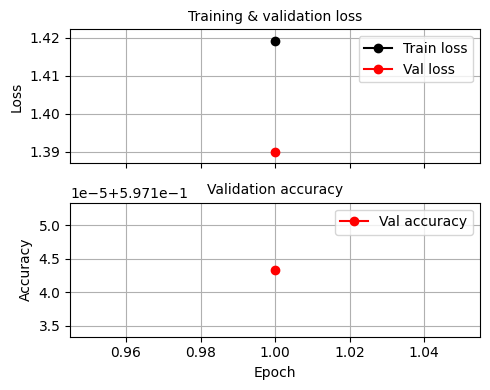

Epoch 1 summary:
  Total epoch time: 106.17s
  Train loss: 1.4193 (time: 85.06s)
  Val   loss: 1.3899, Val acc: 0.5971 (time: 21.11s)
Saved checkpoint to: /content/checkpoints/model_last/FootballTransformer_20-12_22:42_epoch1.pt
Saved checkpoint to: /content/checkpoints/model_best/FootballTransformer.pt
New best model based on validation loss
  LR now: 1.000000e-04

Training finished.
Best validation loss seen: 1.3899
Best checkpoint saved at:  /content/checkpoints/model_best
Last checkpoint saved at:  /content/checkpoints/model_last


In [73]:
# Train from start
history_transformer = train_model(
    model = transformer_model,
    optimizer = optimizer_transformer,
    scheduler = scheduler_transformer,
    num_epochs=num_epochs,
    hist_path=save_hist,
    resume_ckpt=None,
    use_amp=use_amp)

#### Run this cell if you want to train from a checkpoint
If training was interrupted as some point, or the model should be trained for longer, please continue training using the cells below.

In [ ]:
# train from checkpoint
# re-initialize because google colab :/
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True)
history = train_model(num_epochs=num_epochs,
                      hist_path=save_hist,
                      resume_ckpt=last_ckpt_path,
                      use_amp=use_amp)

## Part 4: Results

Here we are going to present the results of this project. That is, our main variable of interest is model prediction performance, measured via the test set accuracies. All models will be compared on this metric. All models have been trained on the same training set, and validation set performance has been tracked during training. Similarly, the same test set is going to be used to compare model performance. The model state being used, is going to be the instance where each model achieved the highest validation accuracy. Additionally, we included confusion matrices to gain more insights into what kind of mistakes the models make and how they differ from each other.

**TEST SET ACCURACY**

In [77]:

def test_model(model, test_loader, hist_path, optimizer, best_ckpt_path = best_ckpt_path, suppress_print = False):
    """Convenience function to get the test performance and immediately print it"""

    # Select the model with the highest performance
    ckpt_path = os.path.join(best_ckpt_path, model.__class__.__name__ + ".pt")
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    print("Loaded best checkpoint from:", best_ckpt_path)
    print("Best val loss stored in ckpt:", ckpt.get("best_val_loss", "N/A"))

    test_loss, test_acc, conf_mat = one_epoch(model = model, optimizer=optimizer, dataloader=test_loader, epoch_idx=0, use_amp=use_amp, train = False)

    if not suppress_print:
        print("\n=== TEST RESULTS ===")
        print(f"Test loss: {test_loss:.4f}")
        print(f"Test acc : {test_acc:.4f}")

    save_hist = hist_path + model.__class__.__name__ + f"_history_epoch{num_epochs}.pt"
    history = torch.load(save_hist, weights_only = False)
    last_train_loss = history["train_loss"][-1]
    last_val_loss = history["val_loss"][-1]
    last_val_acc = history["val_acc"][-1]

    if not suppress_print:
        print("\n=== VALIDATION RESULTS ===")
        print(f"Validation loss: {last_val_loss:.4f}")
        print(f"Validation acc : {last_val_acc:.4f}")

    return test_loss, test_acc, last_val_acc, conf_mat


In [78]:
test_loss, test_acc, last_val_acc, conf_mat = test_model(
    transformer_model,
    hist_path = save_hist,
    optimizer = optimizer_transformer,
    best_ckpt_path = best_ckpt_path,
    test_loader = test_loader
)


Loaded best checkpoint from: /content/checkpoints/model_best
Best val loss stored in ckpt: 1.3898718088030209

=== TEST RESULTS ===
Test loss: 1.3807
Test acc : 0.6002

=== VALIDATION RESULTS ===
Validation loss: 1.3899
Validation acc : 0.5971


**ACCURACY PLOTS**

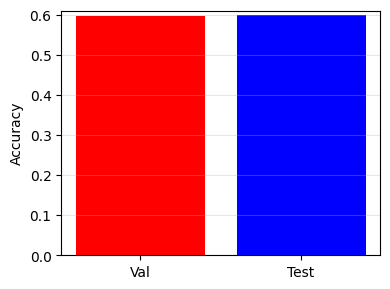

In [79]:
labels = ["Val", "Test"]
values = [last_val_acc, test_acc]
x = np.arange(len(labels))

plt.figure(figsize=(4, 3))
plt.bar(x, values, color=["red", "blue"])
plt.xticks(x, labels)
plt.ylabel("Accuracy")
plt.ylim(0, max(values) + 1e-2)
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

**MAJORITY CLASS AND UNIFORM PROBABILITIES**

In [81]:
history = torch.load(save_hist)
X_test_desc = X_test[X_test["valid_idx"] == 1].copy()


label_counts = X_test_desc["label"].value_counts()
label_probs  = X_test_desc["label"].value_counts(normalize=True)
num_classes = label_counts.shape[0]

print("Num classes in test:", num_classes)
print("Top 10 labels (test):")
print(label_counts.head(5))
print("\nTop 10 label probs (test):")
print(label_probs.head(5))

print("\nMajority-class probability:", label_probs.iloc[0])
print("Uniform probability:", 1/num_classes)
print("Model accuracy:", history["val_acc"][-1])


IsADirectoryError: [Errno 21] Is a directory: '/content/histories/'

#### Confusion Matrix

In [82]:
def plot_conf_mat(history):
    """
    Function takes a history dictionary from training as input.
    Plots the confusion matrix as a heatmap.
    """
    # Compute confusion matrix, move it to CPU and convert to numpy array
    val_conf_mat = history["conf_mat"].compute().cpu().numpy()

    # Get event names in correct order
    event_names = codes_map["input_event"]

    # Turn confusion matrix into pandas dataframe
    val_cm_df = pd.DataFrame(val_conf_mat, index=event_names, columns=event_names)

    # Divide each colum entry by the row sum to get P(pred|target)
    cm_prob = val_cm_df.div(val_cm_df.sum(axis=1), axis=0) # rows are nomalised now

    # The GENERIC:generic class contains events that do not fall into the other classes.
    # Let's give it a more intuitive name.
    # The conversion to probabilities within rows led to NAs because <BOM> is never predicted
    # since the context window can never span two matches. We remove the NAs.
    cm_prob = cm_prob.rename(
        columns={"GENERIC:generic": "OTHER"},
        index={"GENERIC:generic": "OTHER"}).dropna(axis=0)

    # Plot the confusion matrix as a heatmap
    cmap = sns.color_palette("flare", as_cmap=True)
    plt.figure()
    ax = sns.heatmap(cm_prob, cmap=cmap, linewidths=0.5, linecolor="white")
    plt.show()
    plt.close()

In [85]:
history = torch.load("/content/histories/FootballTransformer_history_epoch1.pt", weights_only=False)
plot_conf_mat(history)

ValueError: Shape of passed values is (27, 27), indices imply (28, 28)

## Discussion
In this project we have shown that a transformer model can predict the next event in a football match better than predicting the majority class. However, this conclusion comes with a few important caveats. The LSTM model outperforms the transformer and while not predicting pass every time, the transformer and LSTM model predict clearly predict it for most preceding events, as can be seen from the confusion matrix. Of course there is room for improvement. First, more data is needed to make the model more accurate. Given the billions of tokens, successful LLMs are trained on, the ~4 million data points this model was trained on seems insufficient. Second, it would be interesting to see the models' performance when a currect prediction of a pass is weighted less compared to the correct prediction of all over events. We would expect that with such a weighted loss function, the model would find deeper structure and predict events more precisely. Next, the data could be engineered better: event classes could be collapsed so the model doesn't need to predict all possible events. Similarly, instead of adding continuous and categorical features together, features could be concatenated in order to lose less information. Additionally, end coordinates could be predicted with a separate continuous loss function, which we would expect would lead to the model better 'understanding' whhat a pitch is etc.  
Finally, following the logic of generative language models (e.g. GPT), we would hope that optimizing the transformer model in this project would lead to the possibility of a generative model. Such a model could be fed the beginning of a match and then predict the outcome of a match.
* Also mention here that it would be important to include the position of the players on the pitch as a feature

**Generalizability**
Given the good performance of this model, we would expect this model to perform equally well on other sports data (e.g. Basketball, American football). Further, with event embeddings similarly to the ones used here and in Simpson et al. (2022), any sequence of events that has some inherent structure should be predictable by such a model (e.g. human day-to-day activities), given sufficient training data.
### Takeaways?
* Transformers well-suited for predictions within structures sequences

## 6. Division of labour
**Everyone contributed equally**

## 7. References
Pappalardo, L., Cintia, P., Rossi, A., Massucco, E., Ferragina, P., Pedreschi, D., & Giannotti, F. (2019). A public data set of spatio-temporal match events in soccer competitions. *Scientific Data, 6*(1), 236. https://doi.org/10.1038/s41597-019-0247-7

Simpson, I., Beal, R. J., Locke, D., & Norman, T. J. (2022). Seq2Event: Learning the language of soccer using transformer-based match event prediction. *Proceedings of the 28th ACM SIGKDD Conference on Knowledge Discovery and Data Mining*, 3898–3908. https://doi.org/10.1145/3534678.3539138

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, Ł., & Polosukhin, I. (2017). Attention is all you need. *Advances in Neural Information Processing Systems, 30*.




<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a7159be7-402c-457e-b158-4e16e892eaf8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>